In [12]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from minisom import MiniSom
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import psutil
import warnings
import tracemalloc

In [13]:
# Inizializzazione del dataset e dei parametri
DATA_PATH = "/users/mik2002/som/dataset-processed CIC-IDS-2018/"
FILES = ["processed_infiltration_dataset.csv"]
df_dataset = pd.concat([pd.read_csv(DATA_PATH + file) for file in FILES], ignore_index=True)

In [14]:
df_dataset['Label'].value_counts()

Label
Benign          772775
Infiltration    161060
Name: count, dtype: int64

In [17]:
df_dataset.replace(to_replace=["Benign"], value=0, inplace=True)
df_dataset.replace(to_replace=["Infiltration"], value=1, inplace=True)

/tmp/ipykernel_212053/4113384045.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_dataset.replace(to_replace=["Infiltration"], value=1, inplace=True)


In [18]:
df_dataset['Label'].value_counts()

Label
0    772775
1    161060
Name: count, dtype: int64

In [19]:
# split dataset in data and target 
target = df_dataset.iloc[:len(df_dataset),-1].values
data = df_dataset.iloc[:len(df_dataset),:-1]

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [21]:
# split data in Training and Testing set
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(data, target,test_size=0.2)
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing  set has {} samples.".format(X_test.shape[0]))

Training set has 747068 samples.
Testing  set has 186767 samples.


In [22]:
# since this in supervised classification not unsupervised, this function chooses the class of
# the BMU to be the final class of each instance
def classify(som, data):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = som.labels_map(X_train, y_train)
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

In [32]:
# set hyperparameters
n_neurons = 30
m_neurons = 30
input_len = X_train.shape[1]
sigma = 1.5
learning_rate = 1.2
iterations = 100000

In [35]:
from minisom import MiniSom
# initialization
som = MiniSom(x=n_neurons, y=m_neurons,input_len=input_len,sigma=sigma,learning_rate=learning_rate)
som.random_weights_init(X_train)

In [30]:
%%time
som.train(X_train, iterations, verbose=True)  # random training

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.4126273034778091
CPU times: user 1min 16s, sys: 6.58 s, total: 1min 23s
Wall time: 20.7 s


In [36]:
%%time
y_pred = classify(som, X_test)
report = classification_report(y_test, y_pred, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.8287    0.9987    0.9058    154642
           1     0.5000    0.0063    0.0125     32125

    accuracy                         0.8280    186767
   macro avg     0.6644    0.5025    0.4591    186767
weighted avg     0.7722    0.8280    0.7521    186767

CPU times: user 3min 4s, sys: 43.8 ms, total: 3min 4s
Wall time: 3min 4s


In [73]:
som.topographic_error(X_test)

np.float64(0.9909525144089585)

In [74]:
som.quantization_error(X_test)

np.float64(5.299272141891608)

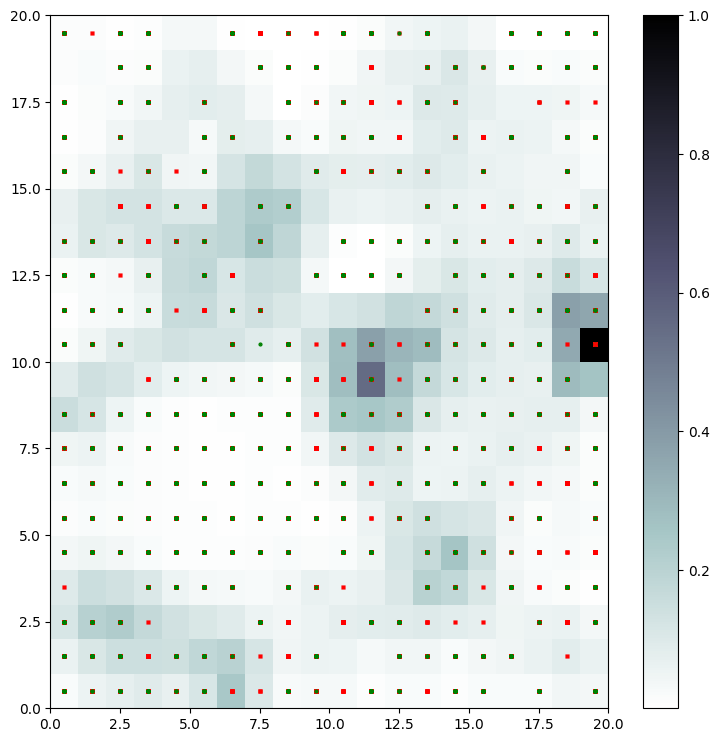

CPU times: user 2min 46s, sys: 2.8 s, total: 2min 49s
Wall time: 2min 49s


In [32]:
%%time
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(9, 9))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the processed_friday_dataset
# different colors and markers for each label
markers = ['o', 's']
colors = ['g', 'r']

for cnt, xx in enumerate(X_test):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[target[cnt]], markerfacecolor=colors[target[cnt]],
             markeredgecolor=colors[target[cnt]], markersize=1, markeredgewidth=2)


plt.show()